Goal : Check if a model trained on dataset1 (Delhi) generalize to dataset2(Pecan Street)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import root_mean_squared_error, mean_absolute_error
import joblib as jb
import datetime as dt

plt.style.use("seaborn-v0_8-darkgrid")

In [2]:
model = jb.load("../models/model_A_lgbm.pkl")
features = jb.load("../models/features_A_lgbm.pkl")
print("Model and Feature loaded.")

Model and Feature loaded.


In [3]:
features

['temp',
 'dwpt',
 'rhum',
 'wdir',
 'wspd',
 'pres',
 'hour',
 'weekday',
 'month',
 'is_weekend',
 'hour_sin',
 'hour_cos',
 'lag_1',
 'lag_24',
 'lag_168',
 'rolling_mean_3',
 'rolling_mean_24']

In [4]:
df = pd.read_csv("../data/Pecan_1/pecan_1_min_part1.csv", parse_dates=["localminute"])
df

,localminute,dataid,use
0,2016-01-01 00:00:00-06:00,26,0.519
1,2016-01-01 00:00:00-06:00,59,1.176
2,2016-01-01 00:00:00-06:00,86,0.469
3,2016-01-01 00:00:00-06:00,114,1.006
4,2016-01-01 00:00:00-06:00,370,0.519
...,...,...,...
2421811,2016-04-30 05:57:00-05:00,101,0.324
2421812,2016-04-30 05:58:00-05:00,101,0.323
2421813,2016-04-30 05:58:00-05:00,86,0.464
2421814,2016-04-30 05:59:00-05:00,86,0.464


In [5]:
df.shape

(2421816, 3)

In [6]:
df.columns

Index(['localminute', 'dataid', 'use'], dtype='object')

In [7]:
cid = 26
df_home = df[df["dataid"]==cid].copy()
df_home.shape

(173022, 3)

In [8]:
df_home = df_home.rename(columns={
    "localminute" : "ds",
    "use" : "y"
})
df_home = df_home.sort_values("ds").reset_index(drop=True)
df_home

,ds,dataid,y
0,2016-01-01 00:00:00-06:00,26,0.519
1,2016-01-01 00:01:00-06:00,26,0.519
2,2016-01-01 00:02:00-06:00,26,0.518
3,2016-01-01 00:03:00-06:00,26,0.519
4,2016-01-01 00:04:00-06:00,26,0.518
...,...,...,...
173017,2016-04-30 04:37:00-05:00,26,0.510
173018,2016-04-30 04:38:00-05:00,26,0.538
173019,2016-04-30 04:39:00-05:00,26,0.506
173020,2016-04-30 04:40:00-05:00,26,0.000


**We can see that 'localminute' pr 'ds' is timezone aware.**

In [9]:
# Explicitly convert to datetime with timezone
df_home["ds"] = pd.to_datetime(df_home["ds"], utc=True)
df_home

,ds,dataid,y
0,2016-01-01 06:00:00+00:00,26,0.519
1,2016-01-01 06:01:00+00:00,26,0.519
2,2016-01-01 06:02:00+00:00,26,0.518
3,2016-01-01 06:03:00+00:00,26,0.519
4,2016-01-01 06:04:00+00:00,26,0.518
...,...,...,...
173017,2016-04-30 09:37:00+00:00,26,0.510
173018,2016-04-30 09:38:00+00:00,26,0.538
173019,2016-04-30 09:39:00+00:00,26,0.506
173020,2016-04-30 09:40:00+00:00,26,0.000


In [10]:
# Hourly Aggregation
df_hourly = (
    df_home
    .set_index("ds")            # Sets 'ds' (timestamp) as index. Resample works only on time-based slices.
    .resample("h")              # Groups data into fixed 1 hour bins. Timestamps within the same hour are grouped together
    .agg({"y" : "mean"})        # Calcs the average energy demand per hour. Agg all vals inside each hour.
    .reset_index()              # Converts ds back from index back to columns.
)

In [11]:
df_hourly

,ds,y
0,2016-01-01 06:00:00+00:00,0.527133
1,2016-01-01 07:00:00+00:00,0.463150
2,2016-01-01 08:00:00+00:00,0.497000
3,2016-01-01 09:00:00+00:00,0.498317
4,2016-01-01 10:00:00+00:00,0.445383
...,...,...
2879,2016-04-30 05:00:00+00:00,0.412917
2880,2016-04-30 06:00:00+00:00,1.417400
2881,2016-04-30 07:00:00+00:00,0.895467
2882,2016-04-30 08:00:00+00:00,0.641883


In [17]:
# Features (Same as Delhi)
df_hourly["hour"] = df_hourly["ds"].dt.hour
df_hourly["weekday"] = df_hourly["ds"].dt.weekday
df_hourly["month"] = df_hourly["ds"].dt.month
df_hourly["is_weekend"] = df_hourly["weekday"].isin([5,6]).astype(int)
df_hourly["hour_sin"] = np.sin(2*np.pi*df_hourly["hour"]/24)
df_hourly["hour_cos"] = np.cos(2*np.pi*df_hourly["hour"]/24)

# Lag and Rolling Mean
df_hourly["lag_1"] = df_hourly["y"].shift(1)
df_hourly["lag_24"] = df_hourly["y"].shift(24)
df_hourly["lag_168"] = df_hourly["y"].shift(168)
df_hourly["rolling_mean_3"] = df_hourly["y"].shift(1).rolling(3).mean()
df_hourly["rolling_mean_24"] = df_hourly["y"].shift(1).rolling(24).mean()

df_hourly.dropna().reset_index(drop=True)
df_hourly

,ds,y,hour,weekday,month,is_weekend,hour_sin,hour_cos,lag_1,lag_24,lag_168,rolling_mean_3,rolling_mean_24
0,2016-01-01 06:00:00+00:00,0.527133,6,4,1,0,1.000000,6.123234e-17,NaN,NaN,NaN,NaN,NaN
1,2016-01-01 07:00:00+00:00,0.463150,7,4,1,0,0.965926,-2.588190e-01,0.527133,NaN,NaN,NaN,NaN
2,2016-01-01 08:00:00+00:00,0.497000,8,4,1,0,0.866025,-5.000000e-01,0.463150,NaN,NaN,NaN,NaN
3,2016-01-01 09:00:00+00:00,0.498317,9,4,1,0,0.707107,-7.071068e-01,0.497000,NaN,NaN,0.495761,NaN
4,2016-01-01 10:00:00+00:00,0.445383,10,4,1,0,0.500000,-8.660254e-01,0.498317,NaN,NaN,0.486156,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2879,2016-04-30 05:00:00+00:00,0.412917,5,5,4,1,0.965926,2.588190e-01,1.924700,0.633900,3.620583,2.172489,1.809899
2880,2016-04-30 06:00:00+00:00,1.417400,6,5,4,1,1.000000,6.123234e-17,0.412917,1.556333,0.498550,1.871144,1.800692
2881,2016-04-30 07:00:00+00:00,0.895467,7,5,4,1,0.965926,-2.588190e-01,1.417400,0.710667,0.520250,1.251672,1.794903
2882,2016-04-30 08:00:00+00:00,0.641883,8,5,4,1,0.866025,-5.000000e-01,0.895467,0.535050,0.527917,0.908594,1.802603


In [18]:
for col in features:
    if col not in df_hourly.columns:
        df_hourly[col] = 0.0

In [20]:
X = df_hourly[features]
y_true = df_hourly["y"]

In [21]:
y_pred = model.predict(X)

In [22]:
def evaluate(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = root_mean_squared_error(y_true, y_pred)
    return mae, rmse

mae, rmse = evaluate(y_true, y_pred)

print(f" Delhi Model on Residential Data → MAE: {mae:.2f}, RMSE: {rmse:.2f}")

 Delhi Model on Residential Data → MAE: 1541.15, RMSE: 1547.54


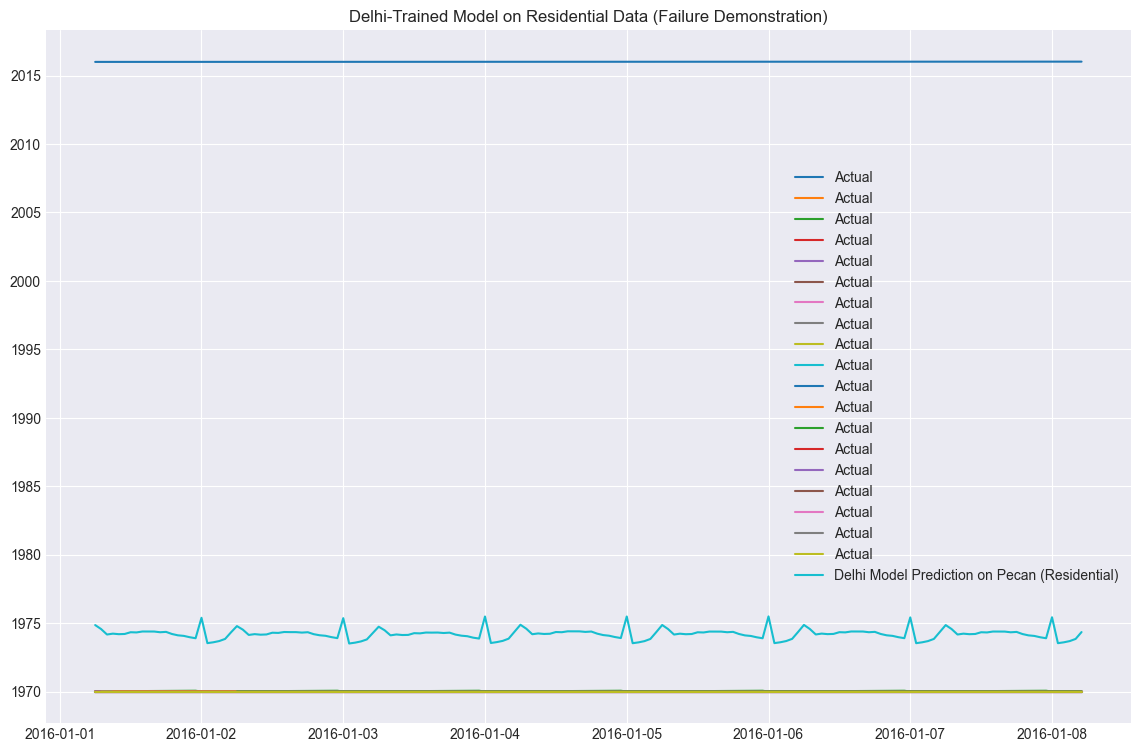

In [23]:
plt.figure(figsize=(14,9))
plt.plot(df_hourly.ds[:168], df_hourly.values[:168], label="Actual")
plt.plot(df_hourly.ds[:168], y_pred[:168], label="Delhi Model Prediction on Pecan (Residential)")
plt.title("Delhi-Trained Model on Residential Data (Failure Demonstration)")
plt.legend()
plt.show()

When applied to residential electricity consumption data, the Delhi-trained LightGBM model exhibited severe performance degradation (MAE ≈ 1541), demonstrating strong domain dependence and highlighting the necessity of domain-specific retraining